# Features from POS_CASH_balance dataset

This notebook creates features from the POS_CASH_balance dataset and displays the distribution of both categorical and numerical features. The POS_CASH_balance dataset contains the monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit

In [1]:
# Importing main modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
%matplotlib inline
pd.set_option('display.max_columns', 2000)

# Defining standard plot options
sns.set(font_scale=1.4)
sns.set_style("white")

# Reverting to old color palette
pal = sns.color_palette("deep")
pal = pal.as_hex()
pal[1], pal[2], pal[3] = pal[2], pal[3], pal[1]
sns.set_palette(pal)

In [2]:
# Loading application dataframe from csv file 
application = pd.read_csv("./data/application.csv")

In [3]:
# Reading data files into csv format
pos_cash_balance = pd.read_csv("./data/POS_CASH_balance.csv")
homecredit_columns_description = pd.read_csv("./data/homecredit_columns_description.csv", encoding="ISO-8859-1")

In [4]:
# Description of columns in pos_cash_balance dataset
description_application = homecredit_columns_description[homecredit_columns_description["Table"] == "POS_CASH_balance.csv"]
for index, row in description_application.iterrows():
    print(row["Row"], row["Description"])

pos_cash_balance.head(20)

SK_ID_PREV  ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)
SK_ID_CURR ID of loan in our sample
MONTHS_BALANCE Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )
CNT_INSTALMENT Term of previous credit (can change over time)
CNT_INSTALMENT_FUTURE Installments left to pay on the previous credit
NAME_CONTRACT_STATUS Contract status during the month
SK_DPD DPD (days past due) during the month of previous credit
SK_DPD_DEF DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
5,2207092,342166,-32,12.0,12.0,Active,0,0
6,1110516,204376,-38,48.0,43.0,Active,0,0
7,1387235,153211,-35,36.0,36.0,Active,0,0
8,1220500,112740,-31,12.0,12.0,Active,0,0
9,2371489,274851,-32,24.0,16.0,Active,0,0


In [5]:
# Extraction of features from POS_CASH_balance dataset

# Creating empty lists for each new feature
nb_pos_cash_list = []
nb_active_pos_cash_list = []  
nb_future_instalments_list = []
nb_total_instalments_list = []
nb_days_past_due_list = []
nb_days_past_due_def_list = []
tot_nb_days_past_due_list = []
tot_nb_days_past_due_def_list = []
fr_active_credit_remaing = []
nb_months_dpd_def_event_list = []

counter = 0
lenght = len(application)
for index, row in application.iterrows():
    counter += 1
    sys.stdout.write('\r'+"Progress:"+str(round(counter/lenght*100,1))+"%")
    
    nb_pos_cash = 0
    nb_active_pos_cash = 0
    nb_future_instalments = 0
    nb_total_instalments = 0
    nb_days_past_due = 0
    nb_days_past_due_def = 0
    tot_nb_days_past_due = 0
    tot_nb_days_past_due_def = 0
    nb_months_dpd_def_event = 0
    
    df = pos_cash_balance[pos_cash_balance["SK_ID_CURR"] == row["SK_ID_CURR"]].sort_values(by="MONTHS_BALANCE", ascending = False)
    if len(df) > 0:
        unique_credit = df["SK_ID_PREV"].unique()
        # Number of past home credit loans
        nb_pos_cash = len(unique_credit)
        # Loop over all unique credits
        for credit in unique_credit:
            tmp = df[df["SK_ID_PREV"] == credit]
        # Number of active past home credit loans (-2 because data is sometimes missing for -1)
            if (tmp.iloc[0]["NAME_CONTRACT_STATUS"] == "Active") & (tmp.iloc[0]["CNT_INSTALMENT_FUTURE"] > 0):
                tmp_current = tmp.iloc[0]
                nb_active_pos_cash += 1
        # Number of future instalments for active credits
                nb_future_instalments += tmp_current["CNT_INSTALMENT_FUTURE"]
        # Total number of instalments for active credits
                nb_total_instalments += tmp_current["CNT_INSTALMENT"]
        # Total current number of DPD for active credits
                nb_days_past_due += tmp_current["SK_DPD"]
        # Total current number of DPD with tolerance for active credits
                nb_days_past_due_def += tmp_current["SK_DPD_DEF"]        
        # Total number of days DPD        
        tot_nb_days_past_due = df[df["CNT_INSTALMENT_FUTURE"] > 0]["SK_DPD"].sum()
        # Total number of days DPD with tolerance        
        tot_nb_days_past_due_def = df[df["CNT_INSTALMENT_FUTURE"] > 0]["SK_DPD_DEF"].sum()
        # Number of months with DPD even with tolerance
        nb_months_dpd_def_event = len(df[(df["SK_DPD_DEF"] > 0) & (df["CNT_INSTALMENT_FUTURE"] > 0)])
        
    nb_pos_cash_list.append(nb_pos_cash)
    nb_active_pos_cash_list.append(nb_active_pos_cash)   
    nb_future_instalments_list.append(nb_future_instalments)
    nb_total_instalments_list.append(nb_total_instalments)
    nb_days_past_due_list.append(nb_days_past_due)
    nb_days_past_due_def_list.append(nb_days_past_due_def)
    tot_nb_days_past_due_list.append(tot_nb_days_past_due)
    tot_nb_days_past_due_def_list.append(nb_days_past_due_def)
    # Fraction of instalments remaining on the credit 
    if nb_total_instalments > 0:
        fr_active_credit_remaing.append(nb_future_instalments/nb_total_instalments)
    else:
        fr_active_credit_remaing.append(np.NaN)
    nb_months_dpd_def_event_list.append(nb_months_dpd_def_event)     



Progress:100.0%

In [6]:
# Function to display description of selected feature
def add_description(table, row, description):
    list_description = [np.NaN, table, row, description, np.NaN]
    homecredit_columns_description.loc[len(homecredit_columns_description)] = list_description
    return homecredit_columns_description

In [7]:
# Creation of new features from credit_card_balance dataset
application["nb_pos_cash_list"] = nb_pos_cash_list
add_description("POS_CASH_balance.csv", "nb_pos_cash_list", "Number of past home credit loans")

application["nb_active_pos_cash_list"] = nb_active_pos_cash_list
add_description("POS_CASH_balance.csv", "nb_active_pos_cash_list", "Number of active past home credit loans")

application["nb_future_instalments_list"] = nb_future_instalments_list
add_description("POS_CASH_balance.csv", "nb_future_instalments_list", "Number of future instalments for active credits")

application["nb_total_instalments_list"] = nb_total_instalments_list
add_description("POS_CASH_balance.csv", "nb_total_instalments_list", "Total number of instalments for active credits")

application["nb_days_past_due_list"] = nb_days_past_due_list
add_description("POS_CASH_balance.csv", "nb_days_past_due_list", "Total current number of DPD for active credits")

application["nb_days_past_due_def_list"] = nb_days_past_due_def_list
add_description("POS_CASH_balance.csv", "nb_days_past_due_def_list", "Total current number of DPD with tolerance for active credits")

application["tot_nb_days_past_due_list"] = tot_nb_days_past_due_list
add_description("POS_CASH_balance.csv", "tot_nb_days_past_due_list", "Total number of days DPD")

application["tot_nb_days_past_due_def_list"] = tot_nb_days_past_due_def_list
add_description("POS_CASH_balance.csv", "tot_nb_days_past_due_def_list", "Total number of days DPD with tolerance")

application["fr_active_credit_remaing"] = fr_active_credit_remaing
add_description("POS_CASH_balance.csv", "fr_active_credit_remaing", "Fraction of instalments remaining on the credit")

application["nb_months_dpd_def_event_list"] = nb_months_dpd_def_event_list
add_description("POS_CASH_balance.csv", "nb_months_dpd_def_event_list", "Number of months with DPD even with tolerance");

In [8]:
# Saving application dataframe into csv file
application.to_csv("./data/application.csv",index=False)

In [9]:
# Saving homecredit_columns_description dataframe into csv file
homecredit_columns_description.to_csv("./data/homecredit_columns_description.csv",index=False)

In [13]:
discrete_features = ["nb_pos_cash_list", "nb_active_pos_cash_list", "nb_months_dpd_def_event_list"]

continuous_features = ["nb_days_past_due_list", "nb_days_past_due_def_list", "nb_future_instalments_list", \
                     "nb_total_instalments_list","tot_nb_days_past_due_list", \
                       "tot_nb_days_past_due_def_list", "fr_active_credit_remaing"]

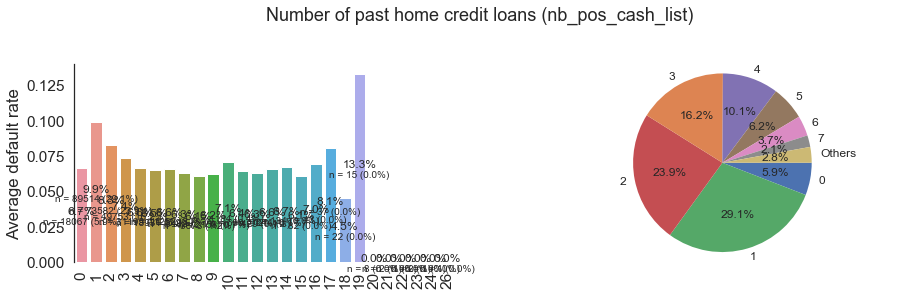

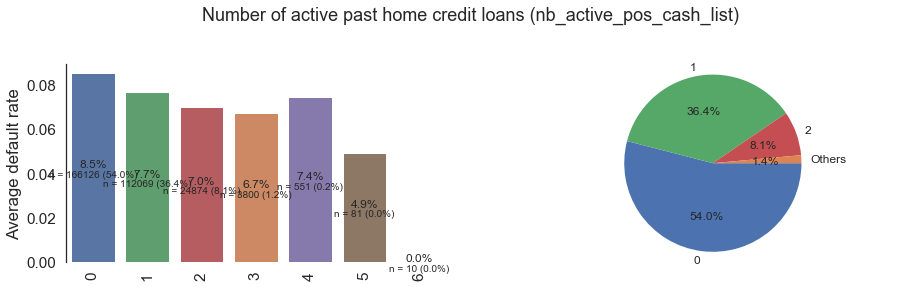

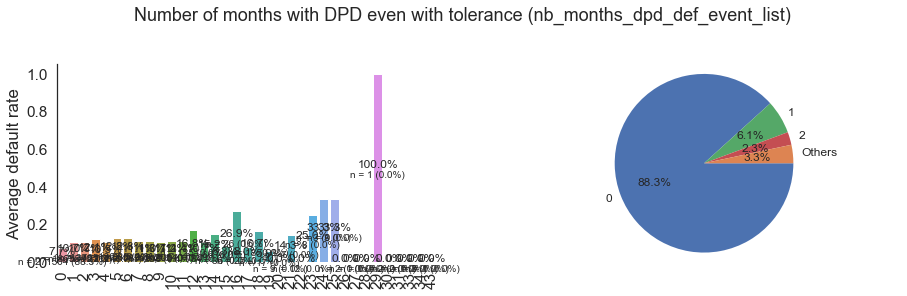

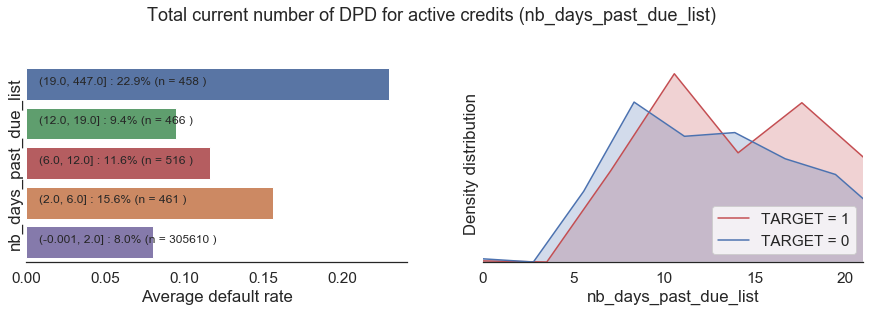

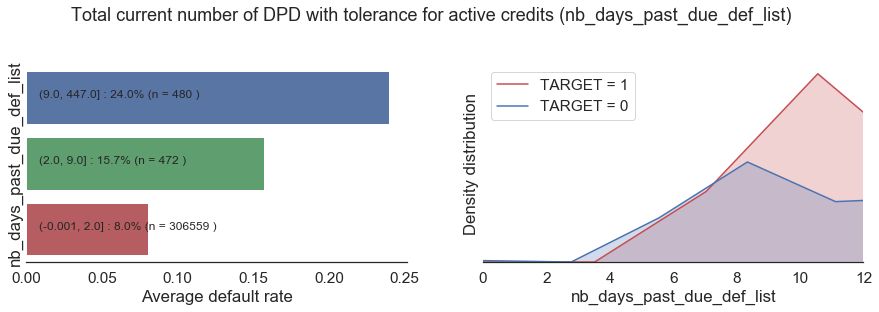

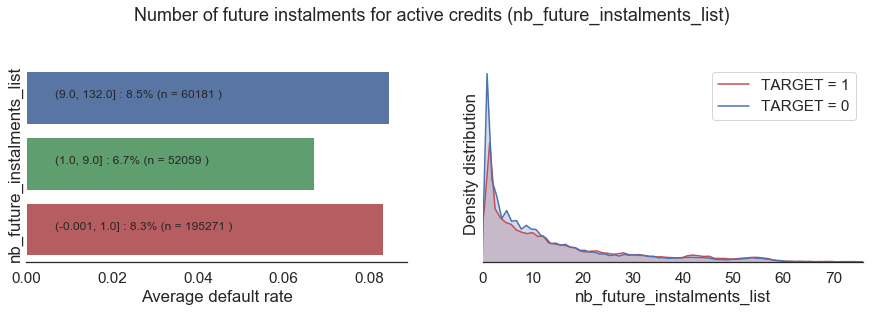

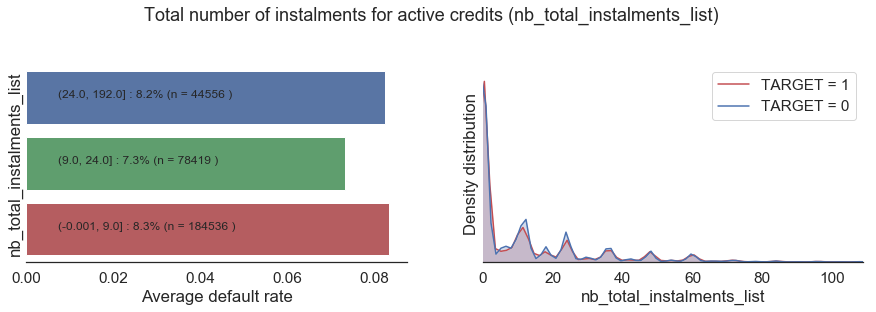

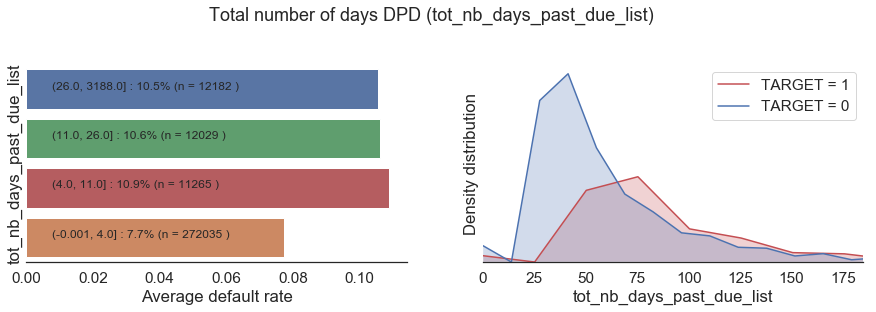

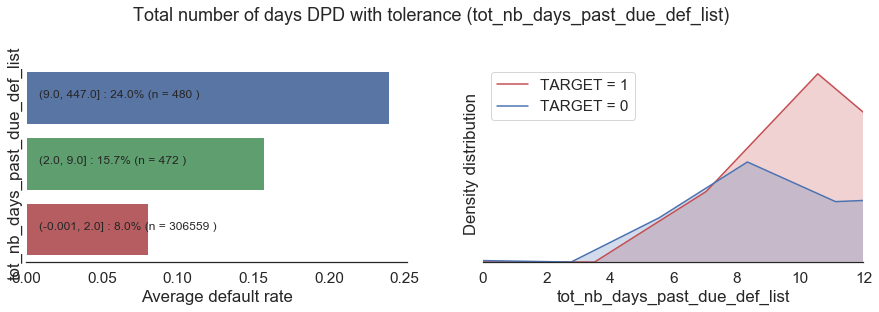

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


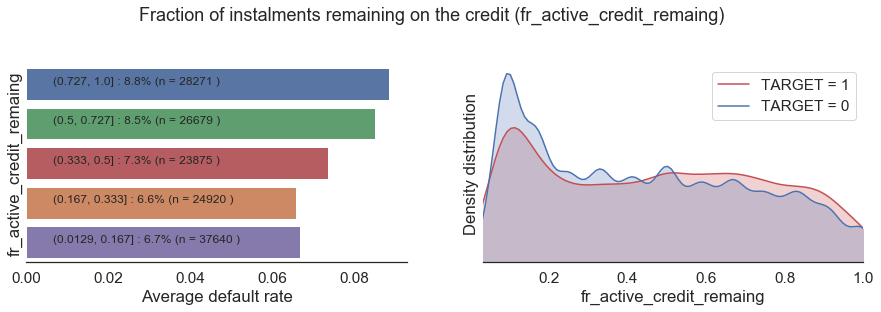

In [14]:
def display_discrete_feature(df, feature, target):
    # Creating figure and axes
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    
    # Print title
    title = homecredit_columns_description[homecredit_columns_description["Row"] == feature]["Description"].tolist()[0] + " (" + feature + ")"
    # If title is too long, reduce font size
    if len(title) <= 100:
        plt.suptitle(title, size = 18)
    else:
        plt.suptitle(title, size = 18*100/len(title))
    
    # Bar plot of mean target as a function of feature value
    df_grouped = df[[feature, target]].groupby([feature]).agg(["mean", "count"])
    # In case of non numerical categorial data, sort by value count
    if type(df_grouped.index[0]) == str:
        df_grouped = df_grouped.sort_values(by = [("TARGET", "count")], ascending = False)
    index = df_grouped.index
    height = df_grouped[("TARGET", "mean")].tolist()
    count = df_grouped[("TARGET", "count")].tolist()
    sns.barplot(index, height, ax = ax1)
    if len(count) >= 5:
        ax1.tick_params(axis='x', rotation=90, labelleft = True)
    ax1.set_xlabel("")
    ax1.set_ylabel('Average default rate')

    sns.despine(bottom=True, ax = ax1)
    # Writing target average and count for each bar plot
    for i, item in enumerate(count):
        ax1.text(x = i , y = height[i]/2, s = str(round(height[i]*100,1))+"%", size = 12, horizontalalignment='center')
        ax1.text(x = i , y = height[i]/2-np.max(height)/20, s = "n = "+str(item)+" ("+str(round(item/len(df)*100, 1))+"%)", size = 10, horizontalalignment='center')

    # Pie chart for the selected feature
    df_value_count = df[feature].value_counts()/len(df[feature].dropna())
    # In case of numerical categorial data, sort by index
    if type(df_value_count.index[0]) != str:
        df_value_count = df_value_count.sort_index()
    # If there are more than 2 categories with low count, then group in Others category
    if len(df_value_count[df_value_count < 2/100]) >= 2:
        df_value_count = df_value_count[df_value_count > 2/100]
        df_value_count["Others"] = 1 - df_value_count.sum()
    df_value_count.plot(kind="pie", autopct="%1.1f%%", ax = ax2, startangle = 0
                        , counterclock = False, textprops=dict(fontsize=12), 
                       wedgeprops = {'linewidth': 0} )
    ax2.set_ylabel("")
    ax2.axis('equal')

    plt.show()
    
    
def display_continuous_feature(df, feature, target, bins):
    # Creating figure and axes
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
   
    # Print title
    title = homecredit_columns_description[homecredit_columns_description["Row"] == feature]["Description"].tolist()[0]
    # If title is too long, reduce font size
    if len(title) <= 100:
        plt.suptitle(title+ " (" + feature + ")", size = 18)
    else:
        plt.suptitle(title+ " (" + feature + ")", size = 18*100/len(title))

    # Barplot of mean target as a function of feature value
    feature_bins = pd.qcut(df[feature], bins, duplicates = "drop")
    while len(feature_bins.unique()) <= 2:
        bins = bins * 5
        feature_bins = pd.qcut(df[feature], bins, duplicates = "drop")
    df2 = df.pivot_table(target, feature_bins).reset_index().sort_values(by = [feature], ascending = False).reset_index(drop = True)
    df3 = df.pivot_table(target, feature_bins, aggfunc='count').reset_index().sort_values(by = [feature], ascending = False).reset_index(drop = True)
    sns.barplot(y=feature, x=target, orient = "h", data = df2, ax = ax1, order = df2[feature])
    height = df2[target]
    count =  df3[target]
    ax1.set_ylabel(feature)
    ax1.set_xlabel('Average default rate')
    ax1.set_yticks([])
    for i, item in enumerate(count):
        ax1.text(y = i , x = min(height)/10, s = str(df2[feature][i]) + " : "+ str(round(height[i]*100,1))+"%" +" (n = "+str(item)+" )", size = 12, horizontalalignment='left')
    sns.despine(left=True, ax = ax1)

    # Kernel Density Estimate of the feature for both target values
    sns.kdeplot(df[df["TARGET"] == 1][feature], shade=True, color = pal.as_hex()[2], ax = ax2, label="TARGET = 1")
    sns.kdeplot(df[df["TARGET"] == 0][feature], shade=True, color = pal.as_hex()[0], ax = ax2, label="TARGET = 0")
    ax2.set_xlabel(feature)
    ax2.set_ylabel('Density distribution')
    ax2.set_yticks([])
    min_x = min(df[df["TARGET"] == 1][feature].quantile(.001), df[df["TARGET"] == 0][feature].quantile(.001))
    max_x = min(df[df["TARGET"] == 1][feature].quantile(.999), df[df["TARGET"] == 0][feature].quantile(.999))
    ax2.set_xlim([min_x, max_x])
    sns.despine(left=True, ax = ax2)
    plt.show()

for feature in discrete_features:
    display_discrete_feature(application[application["train"] == 1], feature, "TARGET")

for index, feature in enumerate(continuous_features):
    display_continuous_feature(application[application["train"] == 1], feature, "TARGET", 5)